In [1]:
library("repr")
options(warn=-1)

# Bayesian Blocks

The Bayesian Block data representation is a non-parametric method based on **Bayesian statistics** to redefine binning of data. 

Invented by Scargle [https://arxiv.org/abs/astro-ph/9711233] in 1998 and updated in 2013 [https://arxiv.org/abs/1207.5578v3] in the context of time-series analysis, it has the following advantages:

- it is able to characterize statistically significant variations, at the same time suppressing the inevitable corrupting observational errors;
- *non parametric* : it is general, does not "fit" data;
- does not require much hypothesis on signal/background shape.

The key idea is to determine the _optimal segmentation_ of data, working with _posterior probabilities_:

$$ P(M | D) \propto P(D | M)P(M)$$

## Fitness function $P(D | M)$

In the following work, the data were considered to follow Cash statistics just as reported in Scargle 2013: if $M(t, \theta)$ is the considered model of the time dependence of the signal, the unbinned log-likelihood is:

$$\log L(\theta) = \sum_n \log M(t_n, \theta) − \in M(t, \theta)dt$$

where the sum is over the events and $\theta$ represents the model
parameters. The integral is over the observation interval and
is the expected number of events under the model. 

In the considered case, $M(t, \lambda) = \lambda$ (constant model), so for block $k$:

$$ \log L^{(k)}(\lambda) = N^{(k)}\log \lambda − \lambda T^{(k)}$$

where $N^{(k)}$ is the number of events in block $k$ and $T^{(k)}$ is
the length of the block. The maximum of this likelihood is at $\lambda = N^{(k)}/T^{(k)}$, yielding:


$$ \log L^{(k)}_{max}+ N^{(k)} = N^{(k)}(\log N^{(k)}− \log T^{(k)})$$

In this way the fitness function (i.e., the likelihood) will be:

- scale invariant
- block-additive

## Prior

Since it is more likely that $N_{blocks} \ll N$, a _geometric prior_ is chosen:

$$ P(N_{blocks})= P_0 \gamma^{N_{blocks}} = \frac{1-\gamma}{1-\gamma^{N+1}} \gamma^{N_{blocks}} $$

It has well-understood properties and is simply implemented in the algorithm. $\gamma$ values are taken to be smaller than $1$ to avoid overfitting. Notice that putting $\gamma=1$ equals to using a flat prior for the bins.

Another possibility is to calibrate the prior as a function of the number of data points $N$ and the correct detection rate $p_0$ ($\equiv 1 - p_1$ false positive rate) on toy pure-noise experiments, leading to the expression:

$$ \texttt{ncp_prior} = 4 - \log(73.53 p_0 N^{-0.478})$$

## The algorithm

The number of possible partitions of data is $2^N$, hence computing all of them is very computationally demanding: a _dynamic programming_ approach is adopted, mimicking mathematical induction:

- we can easily find the optimal binning for a single point, which of course is the optimal one;
- we compute the optimal partition at each iteration from the previously computed ones (mathematical details in the appendices of Scargle 2013). 

In this way, Scargle and collaborators showed that the $2^N$ possible states can be explored in $N^2$ time.

In [2]:
bayesian_blocks <- function(xs, prior=7.61, nn_vec=rep(1,length(xs))){
    
#   Parameters
#   ----------
#   xs : vector, 
#         data to be histogrammed, 'old' binning
#   prior: double,
#         value of ncp-prior, initialized to 7.61 (p0=0.01, N=1000, value find in Scargle 2013)
#   nn_vec: vector,
#         counts of data, inizialized to all 1 if data in not previously binned

#   Returns
#   -------
#   change_points : vector
#         array containing the 'new' bin edges


#   sort input vector in order to create the starting block edges
    xs <- sort(xs)
    begin <- xs[1]
    end <- xs[length(xs)]
    
#   remove 0s to avoid NA in the log computation
    xs <- xs[!(nn_vec==0)]
    nn_vec <- nn_vec[!(nn_vec==0)]
    
    N <- length(xs)
    start <- xs[1]
    stop <- xs[N]
   
#   starting blocks
    blocks <- c(start, 0.5*(xs[2:N]+xs[1:N-1]), stop);
    block_length <- stop - blocks

#   start with first data cell; add one cell at each iteration

    best <- NULL 
    last <- NULL
    supp <- NULL
    
    for (R in 1:N){
#       Compute fit_vec : fitness of last-known block (end at R)
        
#       block width and block count
        arg_log <- block_length[1:R] - block_length[R+1]
        
        nn_cum_vec <- cumsum(nn_vec[R:1])
        nn_cum_vec <- nn_cum_vec[R:1]
        
#       fitness
        fit_vec <- nn_cum_vec * (log(nn_cum_vec) - log(arg_log))
        fit_vec <- fit_vec - prior
        
        supp <- c(0, best) + fit_vec
        
#       R-th changepoint is the maximum of the fitness
        best <- c(best, max(supp))
        last <- c(last, which.max(supp))
         
}    
    
#   find changepoints by iteratively peeling off the last block
    
    index <- last[N]

    change_points <- NULL

    while(index > 1){
        change_points <- c(index, change_points)
        index <- last[index - 1]
    }
    
    change_points <- c(begin, blocks[change_points], end)
    
    return(change_points)
}

## Testing the algorithm

Generate a random dataset to test the algorithm and its performances.

In [3]:
# generate some test data
test <- c(rnorm(1000, 0, 1), rgamma(1000, 9, 2))
test <- test[(test > -5) & (test < 10)]
test <- sort(test)

In [4]:
# rebin the test data, prior values taken as suggested in Scargle paper
cp_h <- bayesian_blocks(test, prior=7.61)
cp_h

[1] -3.2245948 -2.1015279 -1.3648548 -0.5280338  0.6824079  1.3906035
 [7]  2.8281300  5.4039439  6.4971665  7.5833739  9.6587581

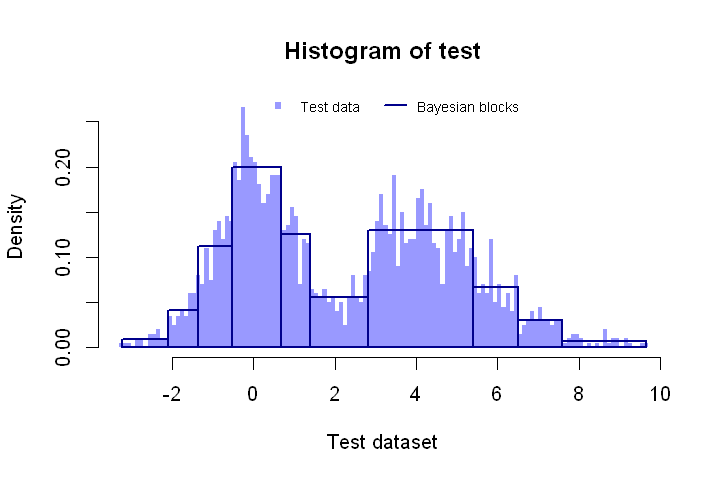

In [5]:
options(repr.plot.width=6, repr.plot.height=4) 
par(lwd=2)

h_t  <- hist(test, breaks=100, freq=FALSE, col=rgb(0,0,1,0.4), lty='blank',
             xlab="Test dataset")
h_bb <- hist(test, breaks=cp_h, freq=FALSE, border='blue4', add=TRUE)

legend('top', col=c(rgb(0,0,1,0.4), 'blue4'), bty='n', 
       lty=c(NA, 1), pch=c(15, NA), cex=0.7, horiz = TRUE,
       legend = c("Test data", "Bayesian blocks")
         )

### Varying the value of `ncp_prior`

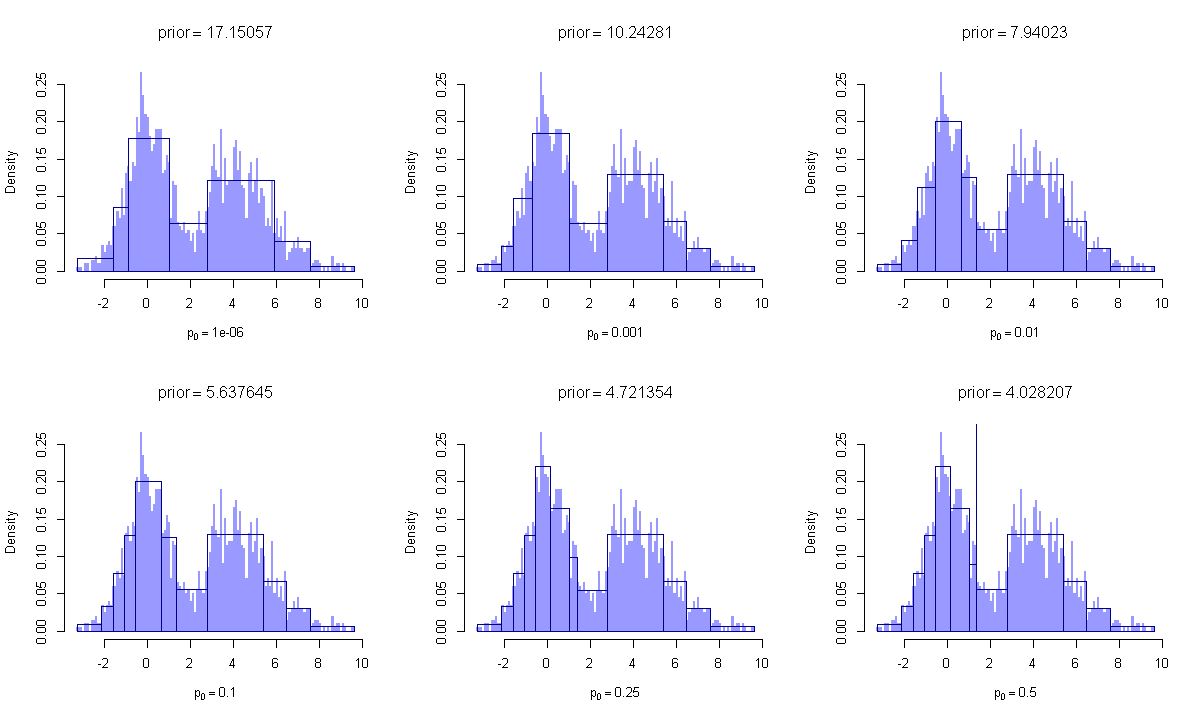

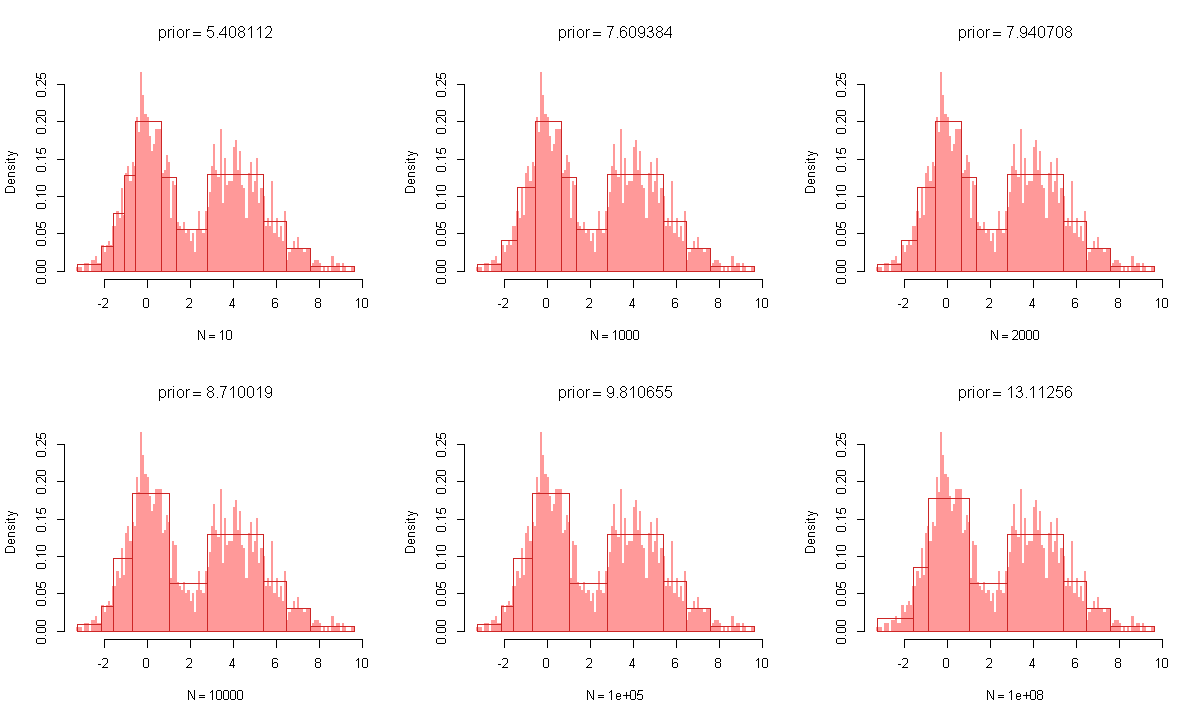

In [6]:
ncp_prior <- function(p0, N){ 4 - log(73.53 * p0 * N^(-0.478))}

p0 <- c(1e-6, 0.001, 0.01, 0.1, 0.25, 0.5)
N  <- c(10, 1000, 2000, 10000, 100000, 1e8)

options(repr.plot.width=10, repr.plot.height=6) 
par(mfrow=c(2,3), lwd=1.5)

for (i in 1:length(p0)){
    cp <- bayesian_blocks(xs = test, prior=ncp_prior(p0[i], length(test)))
    h_t  <- hist(test, breaks=100, freq=FALSE, col=rgb(0,0,1,0.4), lty='blank',
                 xlab= parse(text = paste0(' p[0] == ', p0[i])), 
                 main= parse(text = paste0(' "prior" == ', ncp_prior(p0[i], length(test)) ) ) )
    h_bb <- hist(test, breaks=cp, freq=FALSE, border='blue4', add=TRUE)

}

for (i in 1:length(N)){
    cp <- bayesian_blocks(xs = test, prior=ncp_prior(0.01, N[i]))
    h_t  <- hist(test, breaks=100, freq=FALSE, col=rgb(1,0,0,0.4), lty='blank',
                 xlab= parse(text = paste0(' N == ', N[i])), 
                 main= parse(text = paste0(' "prior" == ', ncp_prior(0.01, N[i]) ) ) )
    h_bb <- hist(test, breaks=cp, freq=FALSE, border='firebrick3', add=TRUE)

}

### Varying the $\gamma$ value with geometric prior

The contribute of the geometric prior in the algorithm simply consist of adding the constant $\log \gamma$ to the fitness of each block, meaning that the input parameter in the previously defined function needs to be equal to $-\log \gamma$.

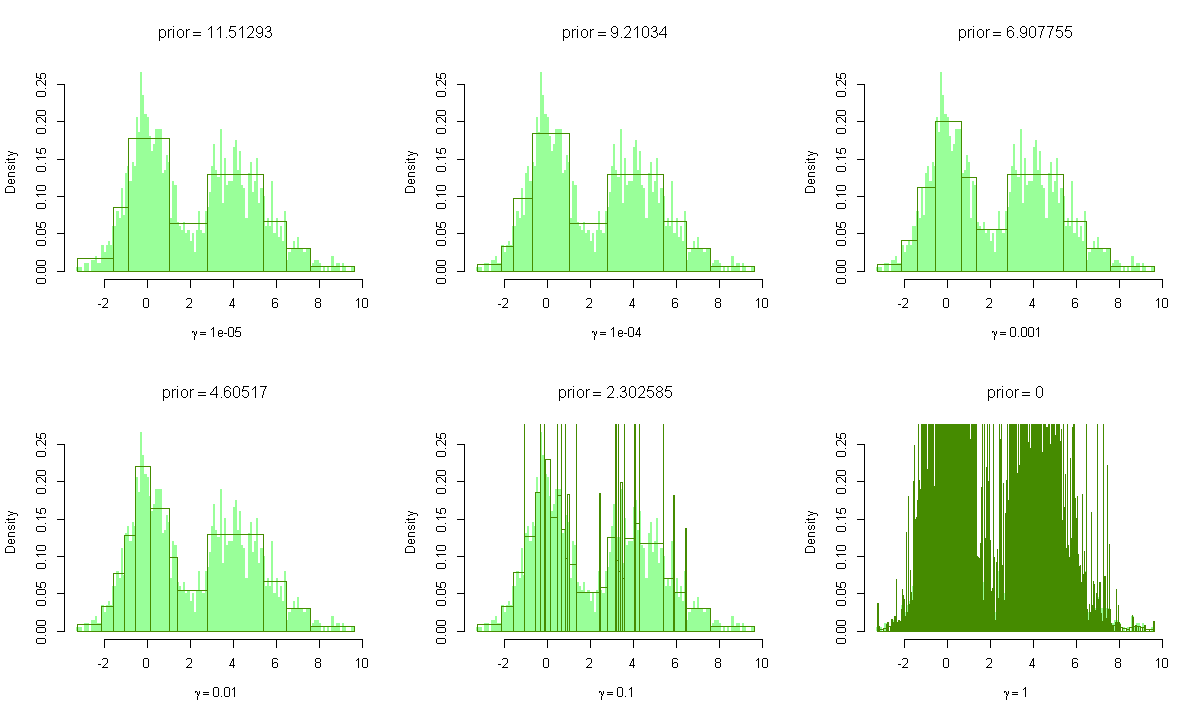

In [7]:
gamma <- c(1e-5, 1e-4, 1e-3, 1e-2, 0.1 ,1)

options(repr.plot.width=10, repr.plot.height=6) 
par(mfrow=c(2,3), lwd=1.5)

for (i in 1:length(gamma)){
    cp <- bayesian_blocks(xs = test, prior=-log(gamma[i]))
    h_t  <- hist(test, breaks=100, freq=FALSE, col=rgb(0,1,0,0.4), lty='blank',
                 xlab= parse(text = paste0(' ~gamma == ', gamma[i])), 
                 main= parse(text = paste0(' "prior" == ', -log(gamma[i]) ) ) )
    h_bb <- hist(test, breaks=cp, freq=FALSE, border='chartreuse4', add=TRUE)

}


## Test on other datasets

In [8]:
# generate some test data
test1 <- c(rnorm(2000, 0, 4))
test1 <- test1[(test1 > -10) & (test1 < 10)]

test2 <- c(rbeta(2000, 0.7, 0.7))
test2 <- test2[(test2 > 0) & (test2 < 15)]

test3 <- c(rcauchy(1000, 1, 0.7), rgamma(1000, 7.5, 1))
test3 <- test3[(test3 > -5) & (test3 < 10)]

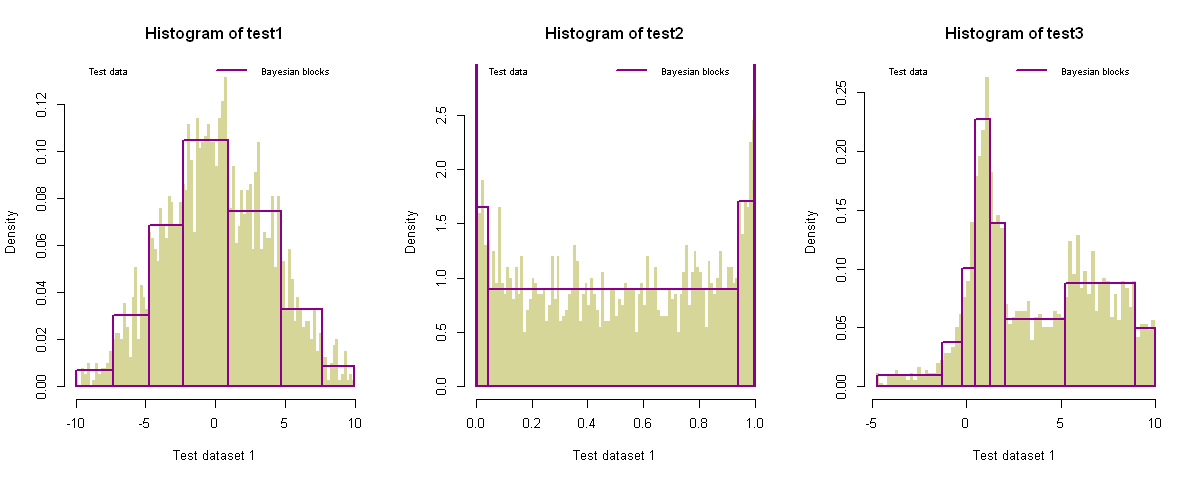

In [9]:
options(repr.plot.width=10, repr.plot.height=4) 
par(lwd=2, mfrow=c(1,3))

cp_h1 <- bayesian_blocks(test1, prior=7.90708)

h_t1  <- hist(test1, breaks=100, freq=FALSE, col=rgb(0.6,0.6,0,0.4), lty='blank',
             xlab="Test dataset 1")
h_bb1 <- hist(test1, breaks=cp_h1, freq=FALSE, border='darkmagenta', add=TRUE)

legend('top', col=c(rgb(0.6,0.6,0,0.4), 'darkmagenta'), bty='n', 
       lty=c(NA, 1), pch=c(15, NA), cex=0.7, horiz = TRUE,
       legend = c("Test data", "Bayesian blocks")
         )

cp_h2 <- bayesian_blocks(test2, prior=7.90708)

h_t2  <- hist(test2, breaks=100, freq=FALSE, col=rgb(0.6,0.6,0,0.4), lty='blank',
             xlab="Test dataset 1")
h_bb2 <- hist(test2, breaks=cp_h2, freq=FALSE, border='darkmagenta', add=TRUE)

legend('top', col=c(rgb(0.6,0.6,0,0.4), 'darkmagenta'), bty='n', 
       lty=c(NA, 1), pch=c(15, NA), cex=0.7, horiz = TRUE,
       legend = c("Test data", "Bayesian blocks")
         )

cp_h3 <- bayesian_blocks(test3, prior=7.90708)

h_t3  <- hist(test3, breaks=100, freq=FALSE, col=rgb(0.6,0.6,0,0.4), lty='blank',
             xlab="Test dataset 1")
h_bb3 <- hist(test3, breaks=cp_h3, freq=FALSE, border='darkmagenta', add=TRUE)

legend('top', col=c(rgb(0.6,0.6,0,0.4), 'darkmagenta'), bty='n', 
       lty=c(NA, 1), pch=c(15, NA), cex=0.7, horiz = TRUE,
       legend = c("Test data", "Bayesian blocks")
         )

## Application on a real dataset

Being the algorithm really flexible and easily applicable, the bayesian blocks method is applied to an energy spectrum, differently from what done in Scargle 2013, where only time based events are treated.

The dataset analysed is collected via a Germanium detector, and concerns the energy spectrum of a $Am241$, $ Co60$ and $Cs137$ radioactive source. In the experimental setting, the source was well sealed and hence we can consider the detected signals as photons emitted by $\gamma$ decay of the source, while the contribute of normally produced $\alpha$ particles can be considered negligible since they were absorbed by the sealing system.


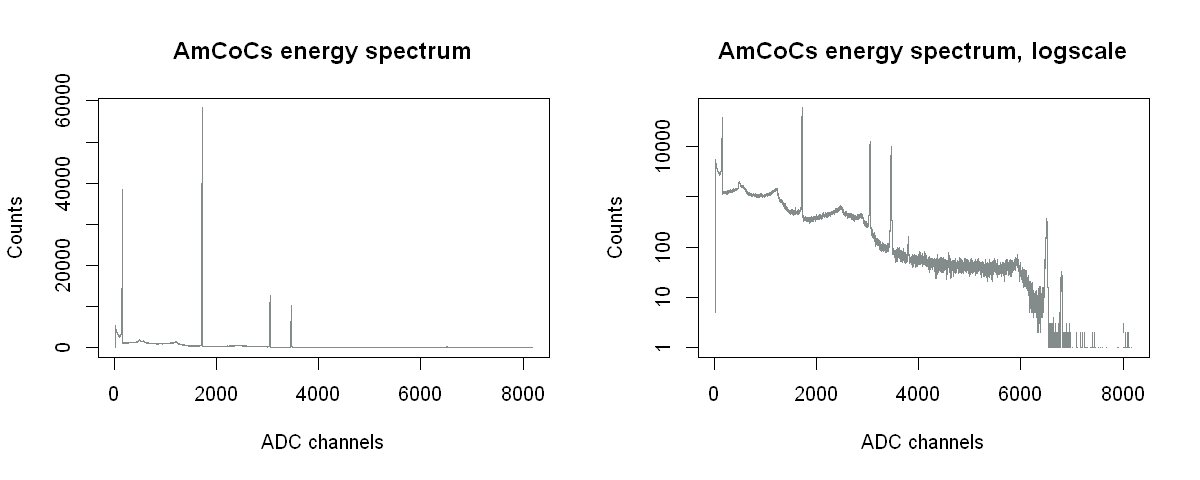

In [10]:
# skip the first two lines as they are only a header
data   <- read.table("./Data/B19036_AmCsCo_20180316.dat", skip=2)
counts <- data[,1]

#set the initial bins as reported in the header of the data file
bins   <- c(0:8191)

# Preliminary computation: start data at the first non-empty bin

idx    <- which(counts >0)[1]
counts <- counts[idx:length(counts)]
bins   <- bins[idx:length(bins)]

options(repr.plot.width=10, repr.plot.height=4)  #to set graph size
par(mfrow=c(1,2))

plot(bins, counts, type='s', lwd=0.5, col= 'azure4',
     xlab="ADC channels", ylab="Counts", main="AmCoCs energy spectrum")
plot(bins, counts, type='s', lwd=0.5, col= 'azure4', log='y',
     xlab="ADC channels", ylab="Counts", main="AmCoCs energy spectrum, logscale")

Before applying the algorithm, a function to assign the proper bin value to rebinned histogram is defined: this is necessary due to the structure of the collected data.

In [11]:
rebin_bb <- function(bins, counts, change_points){

#   Parameters
#   ----------
#   bins : vector, 
#         'old' bin edges
#   counts: vector,
#         counts assigned to old binning
#   change_points: vector,
#         'new' binning

#   Returns
#   -------
#   rebin : vector
#         values assigned to the new bins
    
    rebin <- NULL
    y <- 0
#   assume that old binning is evenly spaced
    dn <- bins[2]-bins[1]
    
    for (i in 1:(length(change_points)-1)){
        ifelse( ( bins < change_points[i+1] ) & ( bins > change_points[i] ),
               { y <- sum(counts[bins < change_points[i+1] & bins > change_points[i]])
                 y <- y/(dn*length(counts[bins < change_points[i+1] & bins > change_points[i]]))
                 rebin <- c(rebin, y)},
               next
            )
    }
#   need for proper data presentation
    rebin <- c(0,rebin,0)
    
    return(rebin)
}

Finally, we can perform the rebinning of the dataset. We will use as prior the computed value of $7.61$ at first, then we will also analyze some different values of the prior.

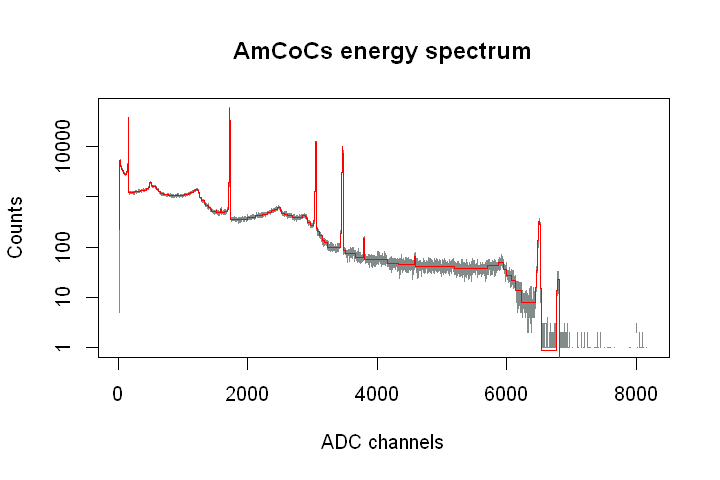

In [12]:
cp <- bayesian_blocks(xs = bins, prior = 7.61, nn_vec = counts)
rebin <- rebin_bb(bins = bins, counts = counts, change_points = cp)

options(repr.plot.width=6, repr.plot.height=4)  #to set graph size

plot(bins, counts, col= 'azure4', type='s', lwd=0.1, log='y',
     xlab="ADC channels", ylab="Counts", main="AmCoCs energy spectrum")
lines(cp, rebin, type='s', col='red')


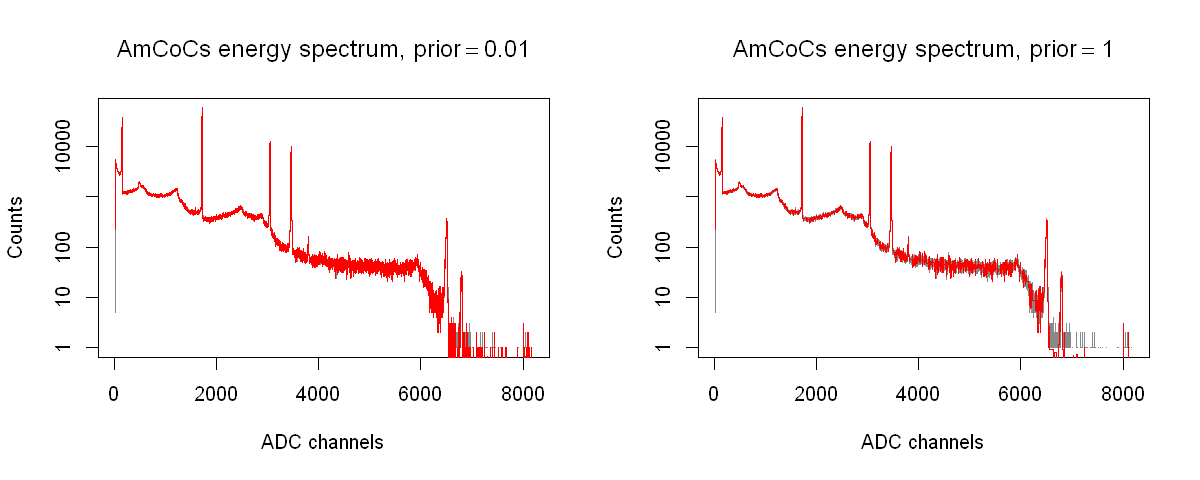

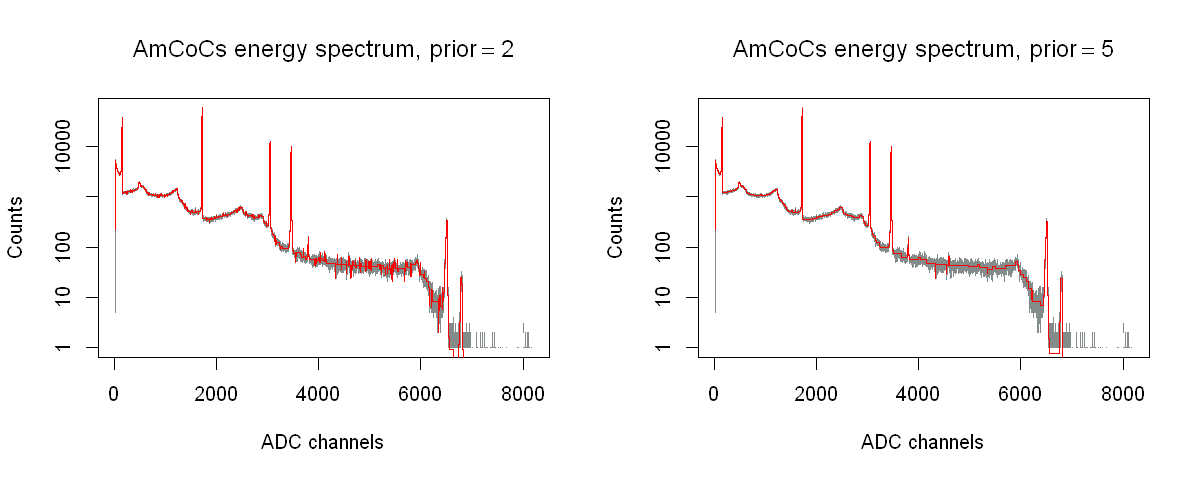

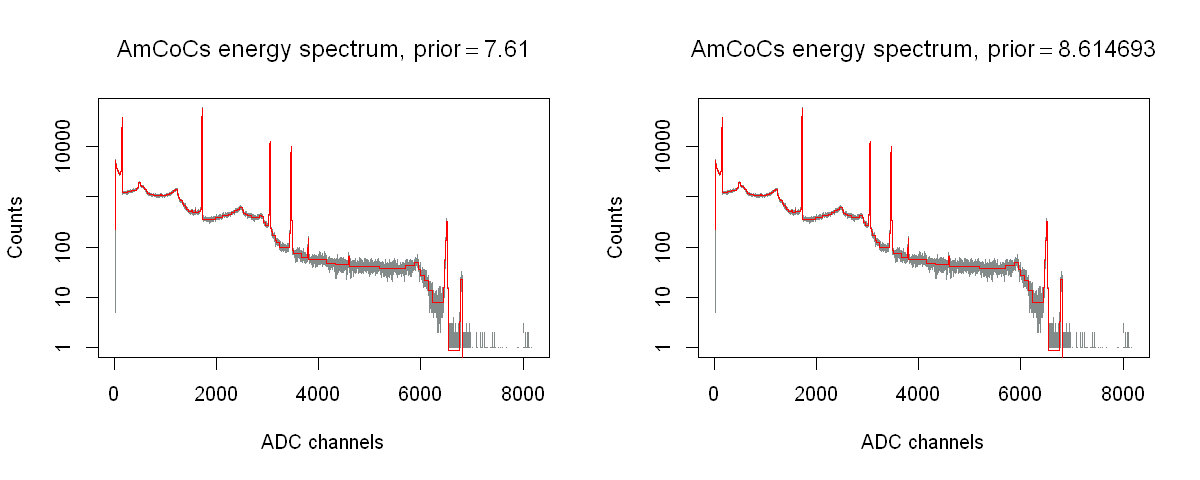

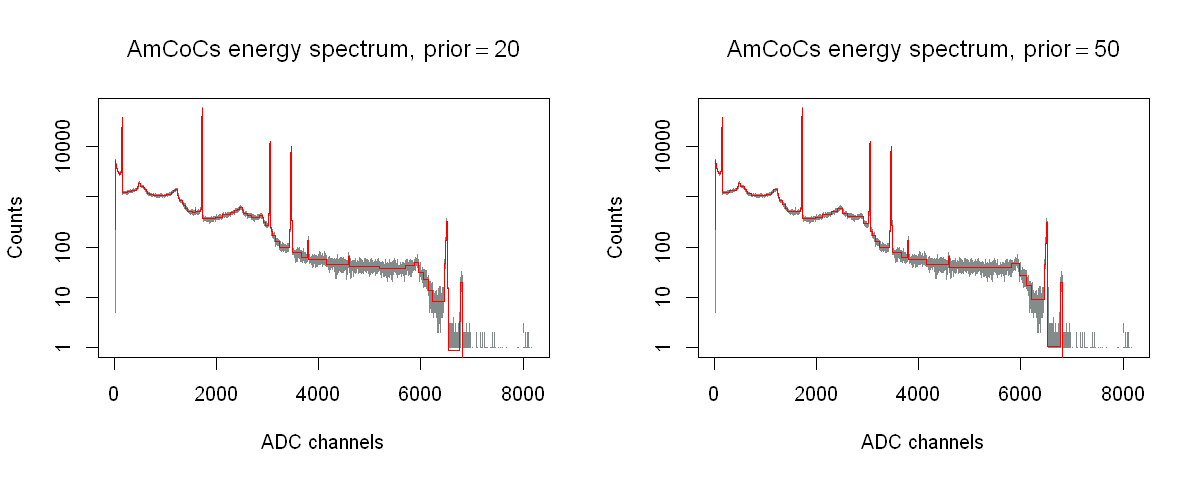

In [13]:
test_priors <- c(1e-2, 1, 2, 5, 7.61, ncp_prior(p0 = 0.01, N = 8192), 20, 50)

options(repr.plot.width=10, repr.plot.height=4)  #to set graph size
par(mfrow=c(1,2))

for (i in 1:length(test_priors)){
    cp <- NULL
    rebin <- NULL
    cp <- bayesian_blocks(xs = bins, prior = test_priors[i], nn_vec = counts)
    rebin <- rebin_bb(bins = bins, counts = counts, change_points = cp)

    plot(bins, counts, col= 'azure4', type='s', lwd=0.1, log='y',
         xlab="ADC channels", ylab="Counts",
         main= parse(text = paste0(' "AmCoCs energy spectrum, prior" == ', test_priors[i] ) ) )
    lines(cp, rebin, type='s', col='red')
}

## Further studies

- data that contain highly-repeated unique values may result pathological for the algorithm. See https://medium.com/@janplus/stratified-bayesian-blocks-2bd77c1e6cc7 for a possible solution (Stratified Bayesian Blocks)
- try different fitness functions (see Appendix of Scargle 2013)
